In [ ]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
import numpy as np
import pickle
import os

Encoder Class:
Encodes input images into latent vectors.
Includes a save_latent method to store latent vectors into a binary file.

Decoder Class:
Reconstructs the images from latent vectors.

Autoencoder Pipeline: Combines Encoder and Decoder for training. It uses mean squared error (MSE) loss for pixel-wise comparison.

Visualization: The code shows original and reconstructed images for qualitative evaluation.

File Saving: Latent vectors are stored as a .bin file for potential downstream tasks.

In [34]:
# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [35]:
# Flatten the images for input to the model
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

In [36]:
# Define Encoder class
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = Flatten()
        self.fc1 = Dense(latent_dim, activation='relu')
        self.fc2 = Dense(latent_dim, activation='linear')

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)

    def save_latent(self, latent_vectors, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(latent_vectors, f)
        print(f"Latent vectors saved to {filepath}")


In [37]:
class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(28 * 28, activation='sigmoid')  # Output as 1D vector

    def call(self, x):
        x = self.fc1(x)
        return self.fc2(x)

In [38]:
# Autoencoder training pipeline
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [39]:
# Instantiate the model
latent_dim = 128
autoencoder = Autoencoder(latent_dim)

In [40]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [41]:
# Train the autoencoder
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0675 - val_loss: 0.0209
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201 - val_loss: 0.0169
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163 - val_loss: 0.0147
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144 - val_loss: 0.0136
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [42]:
# Save the latent vectors for the test set
latent_vectors = autoencoder.encoder(x_train).numpy()
encoder = autoencoder.encoder
encoder.save_latent(latent_vectors, 'latent_vectors.bin')

Latent vectors saved to latent_vectors.bin


In [43]:
# Decode some examples for visualization
decoder = autoencoder.decoder
reconstructed_images = decoder(latent_vectors[:30]).numpy()

In [44]:
# print max and min values of the reconstructed images
print(f"Max value in reconstructed images: {np.max(reconstructed_images)}")
print(f"Min value in reconstructed images: {np.min(reconstructed_images)}")

Max value in reconstructed images: 0.9930954575538635
Min value in reconstructed images: 3.982174832939389e-12


Range of data is 0-1 so we scale it to 0-255 

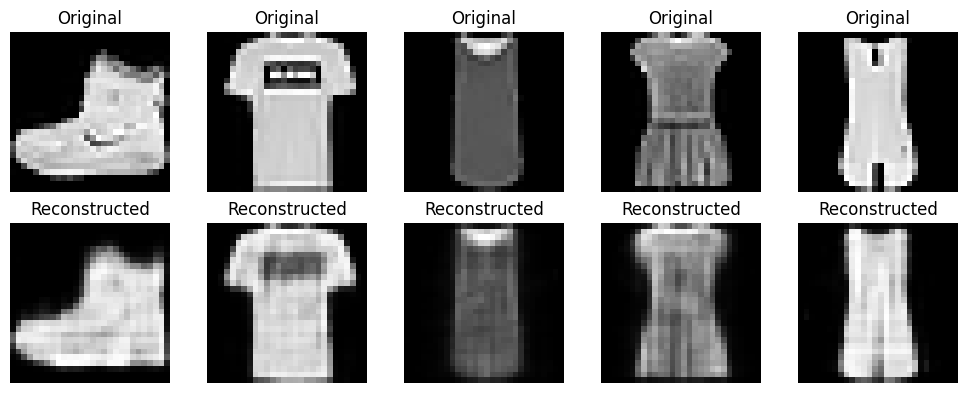

In [ ]:
# Display original and reconstructed images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(5):
    # Original images
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28)*255, cmap='gray') # Rescale to 0-255 and display
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i].reshape(28, 28)*255, cmap='gray')    # Rescale to 0-255 and display
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Find mse psnr and ssim for the reconstructed images
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

mse_values = []
psnr_values = []
ssim_values = []
rmse_values = []

for i in range(30):
    x_train_img = x_train[i].reshape(28, 28)*255    # Rescale to 0-255 and reshape
    x_train_img = x_train_img.astype('uint8')       # Convert to uint8
    x_train_img = np.clip(x_train_img, 0, 255)      # Clip to 0-255
    reconstructed_images_img = reconstructed_images[i].reshape(28, 28)*255  # Rescale to 0-255 and reshape
    reconstructed_images_img = reconstructed_images_img.astype('uint8')     # Convert to uint8
    reconstructed_images_img = np.clip(reconstructed_images_img, 0, 255)    # Clip to 0-255
    mse_values.append(mse(x_train_img, reconstructed_images_img))   # Calculate MSE
    psnr_values.append(psnr(x_train_img, reconstructed_images_img)) # Calculate PSNR
    ssim_values.append(ssim(x_train_img, reconstructed_images_img)) # Calculate SSIM
    rmse_values.append(np.sqrt(mse(x_train_img, reconstructed_images_img))) # Calculate RMSE

print(f"MSE: {mse_values}")
print(f"PSNR: {psnr_values}")
print(f"SSIM: {ssim_values}")


MSE: [np.float64(618.5573979591836), np.float64(671.7946428571429), np.float64(128.65178571428572), np.float64(420.29974489795916), np.float64(657.1186224489796), np.float64(766.9260204081633), np.float64(432.6275510204082), np.float64(546.6785714285714), np.float64(801.233418367347), np.float64(1140.2767857142858), np.float64(270.88647959183675), np.float64(995.0497448979592), np.float64(740.7372448979592), np.float64(481.97576530612247), np.float64(189.72704081632654), np.float64(422.3380102040816), np.float64(296.11479591836735), np.float64(203.2780612244898), np.float64(283.9375), np.float64(397.66964285714283), np.float64(279.8762755102041), np.float64(239.34821428571428), np.float64(540.5637755102041), np.float64(931.8622448979592), np.float64(207.5497448979592), np.float64(223.39795918367346), np.float64(1342.1926020408164), np.float64(269.4170918367347), np.float64(409.5599489795918), np.float64(344.7780612244898)]
PSNR: [np.float64(20.217003554308988), np.float64(19.8584382457

In [ ]:
# print avg values
print(f"Average MSE: {np.mean(mse_values)}")    
print(f"Average PSNR: {np.mean(psnr_values)}")
print(f"Average SSIM: {np.mean(ssim_values)}")
print(f"Average RMSE: {np.mean(rmse_values)}")

Average MSE: 508.4808248299319
Average PSNR: 21.79396879455345
Average SSIM: 0.7968869419931298
Average RMSE: 21.638596266832966


Now we save the weights for the autoencoder trained and then proceed to run autoencoder on a few more examples.

In [23]:
# Save the weights
autoencoder.encoder.save_weights('encoder_weights.weights.h5')
autoencoder.decoder.save_weights('decoder_weights.weights.h5')